In [1]:
from transformers import logging
from transformers import BertModel, BertTokenizer
from transformers import pipeline
import torch
import torch.nn as nn
from torch.nn.functional import normalize, log_softmax

In [2]:
logging.set_verbosity_error()
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
from LamaTRExData import LamaTRExData
from SentenceComparison.SentenceComparison import SentenceComparison 
from ModelHelpers.fill_mask_helpers import get_probability_from_pipeline_for_token
from relation_templates.templates import get_templates, get_relation_meta, relations, relation_names
from PipelineCacheWrapper.PipelineCacheWrapper import PipelineCacheWrapper

In [4]:
USELESS_WORD = "Erftwerk"
UNKNOWN_TOKEN = "[UNK]"
MASK = "[MASK]"
OBJ_LABEL = "obj-label"
SUBJ_LABEL = "sub-label"
VOCABULARY_SIZE = 28996
words = [] 

In [5]:
#relations = ["P140", "P127", "P36", "P159"]
#relations = ["P1303"]
#relations = ["P19", "P413", "P159", "P103"]
len(relations)

41

In [6]:
%%time
model = PipelineCacheWrapper('fill-mask', model="bert-base-cased", top_k=500)

CPU times: user 17.1 s, sys: 4.12 s, total: 21.2 s
Wall time: 26.9 s


In [7]:
TREx = LamaTRExData(relations = relations)
TREx.load()

In [8]:
@torch.no_grad()
def metric(sentence: str, token: str):
    prob = get_probability_from_pipeline_for_token(model(sentence), token)
    return prob

In [9]:
Comparer = SentenceComparison(relations, get_templates, metric, MASK, get_relation_meta)

In [10]:
Comparer.compare(TREx.data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 982/982 [00:00<00:00, 3484.76it/s]


%%time
model.save_to_cache()

In [11]:
Comparer.print_global_for_latex()

P17 & 0.153 & 0.033 & 0.190 & 0.144\\
P19 & 0.067 & 0.002 & 0.002 & 0.001\\
P20 & 0.068 & 0.001 & 0.001 & 0.001\\
P27 & 0.002 & 0.133 & 0.034 & 0.162\\
P30 & 0.134 & 0.016 & 0.025 & 0.009\\
P31 & 0.225 & 0.000 & 0.002 & 0.001\\
P36 & 0.481 & 0.491 & 0.439 & 0.269\\
P37 & 0.422 & 0.249 & 0.182 & 0.240\\
P39 & 0.027 & 0.000 & 0.000 & 0.000\\
P47 & 0.069 & 0.051 & 0.043 & 0.116\\
P101 & 0.035 & 0.027 & 0.000 & 0.012\\
P103 & 0.516 & 0.599 & 0.561 & 0.485\\
P106 & 0.009 & 0.000 & 0.001 & 0.000\\
P108 & 0.012 & 0.001 & 0.001 & 0.001\\
P127 & 0.177 & 0.051 & 0.010 & 0.135\\
P131 & 0.140 & 0.004 & 0.005 & 0.003\\
P136 & 0.037 & 0.001 & 0.025 & 0.000\\
P138 & 0.065 & 0.063 & 0.018 & 0.087\\
P140 & 0.611 & 0.316 & 0.416 & 0.540\\
P159 & 0.172 & 0.169 & 0.163 & 0.158\\
P176 & 0.694 & 0.379 & 0.080 & 0.435\\
P178 & 0.284 & 0.234 & 0.000 & 0.175\\
P190 & 0.015 & 0.017 & 0.016 & 0.015\\
P264 & 0.007 & 0.003 & 0.000 & 0.004\\
P276 & 0.243 & 0.276 & 0.244 & 0.271\\
P279 & 0.229 & 0.023 & 0.027 & 0.01

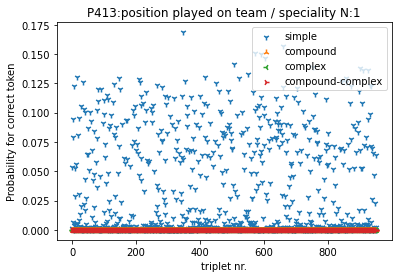

In [12]:
Comparer.plot_comparison_for_relation("P413", "Probability for correct token")

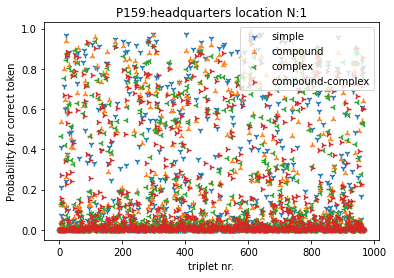

In [13]:
Comparer.plot_comparison_for_relation("P159", "Probability for correct token")

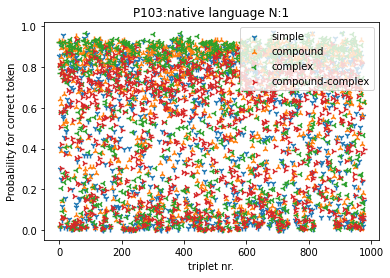

In [14]:
Comparer.plot_comparison_for_relation("P103", "Probability for correct token")

In [15]:
import numpy as np

In [19]:
[(key, np.mean(values)) for (key,values) in Comparer.total_result.items()]

[('simple', 0.1552525554947729),
 ('compound', 0.09172680123699231),
 ('complex', 0.07558401344985012),
 ('compound-complex', 0.10402285062561831)]

In [20]:
ONE_TO_ONE = "1:1"
N_TO_ONE = "N:1"
N_TO_M = "N:M"
CARDINALITIES = [ONE_TO_ONE, N_TO_ONE, N_TO_M]

In [21]:
for card in CARDINALITIES:
    print(card)
    print([(key, np.mean(values)) for (key,values) in Comparer.cardinality_result[card].items()])

1:1
[('simple', 0.5215649250865355), ('compound', 0.5159256315456587), ('complex', 0.4895574153899007), ('compound-complex', 0.3557188931812573)]
N:1
[('simple', 0.19217369242095536), ('compound', 0.09929994170804501), ('complex', 0.09247145093160726), ('compound-complex', 0.12073097425851298)]
N:M
[('simple', 0.06358833306183154), ('compound', 0.04605857487117898), ('complex', 0.0146908502137699), ('compound-complex', 0.055927992463645805)]
